# Importações

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px
from sqlalchemy import create_engine
from statsmodels.tsa.seasonal import STL
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA
from utilsforecast.plotting import plot_series
from datetime import date, timedelta
import calendar
from coreforecast.scalers import boxcox_lambda, boxcox, inv_boxcox
from scipy.stats import entropy
import os
import glob
import pickle

c:\Users\joana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Conexão

In [2]:
df_daily_filled = pd.read_csv('../df_daily_filled.csv', parse_dates=['detected'], dtype='int32')
df_daily_filled = df_daily_filled.set_index('detected')
df_daily_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 943 entries, 2021-08-01 to 2024-02-29
Data columns (total 62 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   direction_2   943 non-null    int32
 1   count_2       943 non-null    int32
 2   direction_3   943 non-null    int32
 3   count_3       943 non-null    int32
 4   direction_4   943 non-null    int32
 5   count_4       943 non-null    int32
 6   direction_5   943 non-null    int32
 7   count_5       943 non-null    int32
 8   direction_6   943 non-null    int32
 9   count_6       943 non-null    int32
 10  direction_7   943 non-null    int32
 11  count_7       943 non-null    int32
 12  direction_8   943 non-null    int32
 13  count_8       943 non-null    int32
 14  direction_9   943 non-null    int32
 15  count_9       943 non-null    int32
 16  direction_10  943 non-null    int32
 17  count_10      943 non-null    int32
 18  direction_11  943 non-null    int32
 19  count_11  

In [3]:
df_loc = pd.read_csv('../all_counter_locations.csv')
df_loc.info()
print()
print(df_daily_filled.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   locationId         31 non-null     int64  
 1   tenantIdentifier   31 non-null     object 
 2   name               31 non-null     object 
 3   cp7                31 non-null     object 
 4   freguesia          31 non-null     object 
 5   directionPositive  0 non-null      float64
 6   directionNegative  0 non-null      float64
 7   latitude           31 non-null     float64
 8   longitude          31 non-null     float64
dtypes: float64(4), int64(1), object(4)
memory usage: 2.3+ KB

            direction_2  count_2  direction_3  count_3  direction_4  count_4  \
detected                                                                       
2021-08-01          219      327          155      323          138      424   
2021-08-02          144      252          194      381          117

### Datas especiais

In [4]:
def calcular_pascoa(ano):
    """Calcula a data da Páscoa para um dado ano (algoritmo de Meeus/Jones/Butcher)."""
    a = ano % 19
    b = ano // 100
    c = ano % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19 * a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2 * e + 2 * i - h - k) % 7
    m = (a + 11 * h + 22 * l) // 451
    mes = (h + l - 7 * m + 114) // 31
    dia = ((h + l - 7 * m + 114) % 31) + 1
    return date(ano, mes, dia)

#feriados 
def calcular_feriados_portugal(anos, incluir_lisboa=False):
    feriados = []

    for ano in anos:
        # Feriados
        feriados += [
            date(ano, 1, 1),   # Ano Novo
            date(ano, 4, 25),  # Dia da Liberdade
            date(ano, 5, 1),   # Dia do Trabalhador
            date(ano, 6, 10),  # Dia de Portugal
            date(ano, 8, 15),  # Assunção de Nossa Senhora
            date(ano, 10, 5),  # Implantação da República
            date(ano, 11, 1),  # Dia de Todos os Santos
            date(ano, 12, 1),  # Restauração da Independência
            date(ano, 12, 8),  # Imaculada Conceição
            date(ano, 12, 25), # Natal
            date(ano, 6, 13),  # Santo António
        ]

        # Feriados Domingo de Páscoa
        pascoa = calcular_pascoa(ano)
        feriados += [
            pascoa - timedelta(days=47), # Carnaval
            pascoa - timedelta(days=2),  # Sexta-feira Santa
            pascoa + timedelta(days=1),  # Segunda-feira de Páscoa 
            pascoa + timedelta(days=60), # Corpo de Deus
        ]

    return set(feriados)

In [5]:
anos = df_daily_filled.index.year.unique()
feriados = calcular_feriados_portugal(anos, incluir_lisboa=True)

df_daily_filled['holiday'] = df_daily_filled.index.date
df_daily_filled['holiday'] = df_daily_filled['holiday'].apply(
    lambda x: 1 if x in feriados else 0
)

In [6]:
#fim de semana
df_daily_filled['weekend'] = df_daily_filled.index.weekday.isin([5, 6]).astype(int)
df_daily_filled['exog'] = ((df_daily_filled['holiday'] == 1) | (df_daily_filled['weekend'] == 1)).astype(int)

# MSTL forecast

In [7]:
def fill_zeros(df, max_weeks_back=5):
    df_filled = df.copy()
    for col in df_daily_filled.columns:
        if col.startswith('count_'):
            zero_dates = df_daily_filled[df_daily_filled[col] == 0].index
            for datetime in zero_dates:
                for weeks_back in range(1, max_weeks_back + 1):
                    prev_week = datetime - pd.Timedelta(weeks=weeks_back)
                    if prev_week in df_daily_filled.index:
                        prev_value = df_daily_filled.loc[prev_week, col]
                        if prev_value != 0:
                            df_filled.loc[datetime, col] = prev_value
                            break
    return df_filled

In [8]:
def aplica_algoritmo(df, contador_id, exog_col='exog',
                     start_date='2021-08-01', end_date='2022-08-01',
                     season_length=[7], n_jobs=-1, datas_corrigidas_previamente=None):
    
    if contador_id is None:
        raise ValueError("É necessário especificar o 'contador_id'.")
    
    if contador_id not in df_daily_filled.columns:
        raise ValueError(f"Contador {contador_id} não encontrado no DataFrame.")
    
    if exog_col not in df_daily_filled.columns:
        raise ValueError(f"Coluna exógena {exog_col} não encontrada no DataFrame.")
    
    if datas_corrigidas_previamente is None:
        datas_corrigidas_previamente = set()
    
    # 1. Filtrar dados históricos até à data limite
    df_hist = df.loc[start_date:end_date].copy()
    df_hist[contador_id] = df_hist[contador_id].astype(float)

    # 2. Substituir dias com zeros 
    df_hist_corr = fill_zeros(df_hist)
    

    # 3. Preparar dados para StatsForecast
    unique_id = contador_id
    df_model = df_hist_corr[[contador_id, exog_col]].reset_index().assign(unique_id=unique_id)
    df_model.columns = ['ds', 'y', 'X', 'unique_id']
    df_model = df_model[['unique_id', 'ds', 'y', 'X']]

    # 4. Ajustar o modelo
    model = MSTL(season_length=season_length, trend_forecaster=AutoARIMA())
    sf = StatsForecast(models=[model], freq='D', n_jobs=n_jobs)
    sf.fit(df_model)
    
    
    # 5. Previsão (1 dia à frente apenas, para completar fitting)
    future_dates = pd.date_range(start=df_model['ds'].max() + pd.Timedelta(days=1), periods=1, freq='D')
    future_exog_values = [1 if d.date() in feriados else 0 for d in future_dates]

    future_exog = pd.DataFrame({
        'ds': future_dates,
        'X': future_exog_values,
        'unique_id': [contador_id] * len(future_dates)      
    })

    levels=[99.7]
    sf.forecast(df=df_model, X_df=future_exog, h=1, level=levels, fitted=True)

    # 6. Obter previsões in-sample e identificar outliers
    insample_fcst = sf.forecast_fitted_values()
    insample_fcst.columns = ['unique_id', 'ds', 'y', 'fitted', 'lo_99_7', 'hi_99_7']

    anomalies = insample_fcst[
        ~insample_fcst['y'].between(insample_fcst['lo_99_7'], insample_fcst['hi_99_7'])
    ].copy()

    novas_datas_corrigidas = set()

    # 7. Corrigir anomalias
    for _, row in anomalies.iterrows():
        dia = row['ds']
        
        if dia in datas_corrigidas_previamente or dia in novas_datas_corrigidas:
            continue

        y = row['y']
        hi = row['hi_99_7']
        lo = row['lo_99_7']
        historico = df_hist_corr.loc[df_hist_corr.index < dia, contador_id]

        if historico.empty:
            continue

        max_hist = historico.max()

        if y > hi:
            novo_valor = min(hi, max_hist)
        elif y < lo:
            novo_valor = lo
        else:
            continue

        df_hist_corr.loc[dia, contador_id] = novo_valor
        novas_datas_corrigidas.add(dia)


    # 9. Retornar histórico corrigido, anomalias, datas corrigidas e componente semanal
    return df_hist_corr, anomalies, novas_datas_corrigidas

In [9]:
def get_one_more_week_rolling(df, df_hist, weeks_added, janela_semanas=52):
    last_date = df_hist.index.max()
    next_week_start = last_date + pd.Timedelta(days=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    df_next_week = df.loc[next_week_start:next_week_end]

    if df_next_week.empty:
        return df_hist, weeks_added, False

    # Concatenar nova semana
    df_hist_updated = pd.concat([df_hist, df_next_week])

    # Manter janela de tamanho fixo (em semanas)
    dias_janela = janela_semanas * 7
    min_date = df_hist_updated.index.max() - pd.Timedelta(days=dias_janela - 1)
    df_hist_updated = df_hist_updated[df_hist_updated.index >= min_date]

    return df_hist_updated, weeks_added + 1, True

In [10]:
# resultados_corrigidos = [] # <- quando for para todos os contadores esta linha e as 2 proximas não são necessarias
# todas_anomalias = []
# datas_corrigidas_global = set()

# contador_id = 'count_35' # <- quando for para todos os contadores tem de ser eliminada
# exog_col = 'exog'
# start_date = '2021-08-01'
# end_date_inicial = '2022-07-31'
# #max_semanas = 2
# semanas_adicionadas = 0 #quando for para todos os contadores tem de ser eliminada

# # for contador_id in colunas_contadores:  <- par todos os contadores
# #     if not contador_id.startswith("count_"):
# #         continue  # ignora colunas que não são contadores

# #     print(f"\n### PROCESSANDO {contador_id} ###")

# #     resultados_corrigidos = []
# #     todas_anomalias = []
# #     datas_corrigidas_global = set()
# #     semanas_adicionadas = 0

#     # Aplicar primeira vez
# df_hist_atual, anomalies_iniciais, datas_corrigidas = aplica_algoritmo(
#     df=df_daily_filled,
#     contador_id=contador_id,
#     exog_col=exog_col,
#     start_date=start_date,
#     end_date=end_date_inicial,
#     datas_corrigidas_previamente=datas_corrigidas_global
# )

#     # Atualizar listas
# datas_corrigidas_global.update(datas_corrigidas)
# resultados_corrigidos.append(df_hist_atual.copy())
# todas_anomalias.append(anomalies_iniciais)

#     # Loop
# while True:    
# #while semanas_adicionadas < max_semanas:
#     df_hist_atual, semanas_adicionadas, conseguiu_adicionar = get_one_more_week_rolling(
#         df=df_daily_filled,
#         df_hist=df_hist_atual,
#         weeks_added=semanas_adicionadas,
#         #max_weeks=max_semanas
#         janela_semanas=52  # ou outro valor
#     )

#     if not conseguiu_adicionar:
#         print("Não há mais semanas para adicionar.")
#         break

#     df_corrigido, novas_anomalias, novas_datas_corrigidas = aplica_algoritmo(
#         df=df_hist_atual,
#         contador_id=contador_id,
#         exog_col=exog_col,
#         start_date=start_date,
#         end_date=df_hist_atual.index.max().strftime('%Y-%m-%d'),
#         datas_corrigidas_previamente=datas_corrigidas_global
#     )

#     # Filtrar anomalias para ignorar as que já foram corrigidas antes
#     novas_anomalias = novas_anomalias[~novas_anomalias['ds'].isin(datas_corrigidas_global)].copy()

#     # Atualizar conjunto global das datas corrigidas
#     datas_corrigidas_global.update(novas_datas_corrigidas)

#     df_hist_atual = df_corrigido.copy()
#     resultados_corrigidos.append(df_hist_atual.copy())
#     todas_anomalias.append(novas_anomalias)

#     print(f"Semana {semanas_adicionadas} processada com {len(novas_anomalias)} novos outliers.")

In [11]:

# pasta_resultados = "resultados_corrigidos"
# os.makedirs(pasta_resultados, exist_ok=True)

# dados_a_guardar = {
#     "corrigido": resultados_corrigidos,
#     "anomalias": todas_anomalias
# }

# filename = os.path.join(pasta_resultados, f"resultado_{contador_id}.pkl")
# with open(filename, "wb") as f:
#     pickle.dump(dados_a_guardar, f)




In [12]:

pasta_resultados = "resultados_corrigidos"
ficheiros = glob.glob(os.path.join(pasta_resultados, "resultado_count_*.pkl"))

lista_dfs_corrigidos = []
lista_dfs_anomalias = []

for ficheiro in ficheiros:
    nome = os.path.basename(ficheiro)
    contador_id = nome.replace("resultado_", "").replace(".pkl", "")

    with open(ficheiro, "rb") as f:
        dados = pickle.load(f)

    # Parte corrigida
    lista_resultados_corrigidos = dados["corrigido"]
    df_corrigido = pd.concat(lista_resultados_corrigidos, axis=0)
    df_corrigido = df_corrigido[[contador_id]]
    lista_dfs_corrigidos.append(df_corrigido)

    # Parte das anomalias
    lista_anomalias = dados["anomalias"]
    df_anomalias = pd.concat(lista_anomalias, ignore_index=True)
    df_anomalias["contador"] = contador_id  # identificar o contador
    lista_dfs_anomalias.append(df_anomalias)

# Juntar tudo num único DataFrame
df_corrigido_total = pd.concat(lista_dfs_corrigidos, axis=1)
df_corrigido_total = df_corrigido_total[~df_corrigido_total.index.duplicated(keep="last")]

df_anomalias_total = pd.concat(lista_dfs_anomalias, ignore_index=True)

# Prontos para análise:
display(df_corrigido_total.head())
display(df_anomalias_total)



,count_10,count_11,count_12,count_13,count_14,count_15,count_16,count_17,count_19,count_2,...,count_32,count_33,count_34,count_35,count_4,count_5,count_6,count_7,count_8,count_9
detected,,,,,,,,,,,,,,,,,,,,,
2021-08-01,407.0,141.0,1663.0,308.0,121.0,84.0,830.0,279.0,638.0,327.0,...,500.0,769.0,691.0,1149.0,424.0,341.0,673.0,1092.0,106.0,1400.0
2021-08-02,219.0,112.0,1272.0,456.0,116.0,83.0,937.0,349.0,462.0,252.0,...,486.0,590.0,777.0,1163.0,372.0,364.0,907.0,1350.0,91.0,632.0
2021-08-03,245.0,155.0,1152.0,488.0,125.0,104.0,1073.0,391.0,539.0,257.0,...,568.0,699.0,724.0,1194.0,411.0,431.0,914.0,1347.0,115.0,860.0
2021-08-04,300.0,135.0,1182.0,448.0,105.0,99.0,1103.0,370.0,600.0,266.0,...,563.0,626.0,799.0,1236.0,423.0,404.0,890.0,1451.0,104.0,903.0
2021-08-05,246.0,144.0,1125.0,382.0,121.0,88.0,1042.0,338.0,471.0,259.0,...,584.0,602.0,846.0,1245.0,370.0,370.0,887.0,1342.0,107.0,823.0


,unique_id,ds,y,fitted,lo_99_7,hi_99_7,contador
0,count_10,2021-10-31,112.0,267.268474,126.957569,407.579378,count_10
1,count_10,2021-11-28,707.0,350.914460,210.603555,491.225364,count_10
2,count_10,2022-03-20,104.0,278.085172,137.774268,418.396077,count_10
3,count_10,2021-10-29,107.0,237.029712,113.291231,360.768194,count_10
4,count_10,2021-12-20,66.0,199.620194,75.881712,323.358675,count_10
...,...,...,...,...,...,...,...
1008,count_9,2023-08-05,634.0,1300.396207,650.834772,1949.957642,count_9
1009,count_9,2023-08-07,3229.0,1020.153601,305.441314,1734.865889,count_9
1010,count_9,2023-08-08,619.0,1838.649650,1123.937363,2553.361938,count_9
1011,count_9,2022-12-25,159.0,756.109013,200.858145,1311.359882,count_9


In [13]:
display(df_anomalias_total[df_anomalias_total['unique_id']== 'count_12'])

,unique_id,ds,y,fitted,lo_99_7,hi_99_7,contador
52,count_12,2021-10-05,1698.0,1154.056856,653.029074,1655.084637,count_12
53,count_12,2021-10-30,414.0,1039.757730,538.729949,1540.785512,count_12
54,count_12,2021-12-27,622.0,87.716734,-413.311047,588.744516,count_12
55,count_12,2022-03-12,387.0,910.452912,409.425131,1411.480694,count_12
56,count_12,2022-03-20,568.0,1474.763186,973.735404,1975.790967,count_12
57,count_12,2022-04-15,1490.0,971.739593,470.711811,1472.767374,count_12
58,count_12,2022-04-22,194.0,734.139609,233.111827,1235.167390,count_12
59,count_12,2021-10-31,538.0,1042.988164,564.369930,1521.606397,count_12
60,count_12,2021-11-01,902.0,400.600686,-78.017548,879.218919,count_12
61,count_12,2022-08-08,52.0,829.368796,330.386307,1328.351285,count_12


In [14]:
# Selecionar os três primeiros contadores (podes trocar os nomes)
contadores_para_mostrar = ['count_12', 'count_2', 'count_14']

for contador in contadores_para_mostrar:
    fig = px.line(
        df_corrigido_total,
        y=contador,
        title=f"Contagem corrigida – {contador}",
        labels={"index": "Data", contador: "Contagem"},
    )
    fig.update_layout(width=1900, height=350)
    fig.show()



In [15]:
anos = df_corrigido_total.index.year.unique()
feriados = calcular_feriados_portugal(anos, incluir_lisboa=True)

df_corrigido_total['holiday'] = df_corrigido_total.index.date
df_corrigido_total['holiday'] = df_corrigido_total['holiday'].apply(
    lambda x: 1 if x in feriados else 0
)

In [16]:
df_corrigido_total['weekend'] = df_corrigido_total.index.weekday.isin([5, 6]).astype(int)
df_corrigido_total['exog'] = ((df_corrigido_total['holiday'] == 1) | (df_corrigido_total['weekend'] == 1)).astype(int)

# STL

In [17]:
y = df_corrigido_total['count_12']
y_boxcox = boxcox(y, lmbda=0)
best_lambda = boxcox_lambda(y, method='guerrero', season_length=7)
y_boxcox = boxcox(y, best_lambda)
inv_boxcox(y_boxcox, best_lambda).round(0)

array([1663., 1272., 1152., 1182., 1125., 1089., 1420., 1812., 1085.,
       1219., 1246., 1191., 1055., 1232., 1421.,  896., 1115., 1136.,
       1210., 1055., 1339., 1605., 1196., 1061., 1176., 1081., 1000.,
       1460., 1659., 1017., 1059., 1141., 1099., 1039., 1505., 1735.,
       1178.,  902., 1088., 1099., 1130., 1517., 1761.,  807.,  823.,
        961., 1032., 1131., 1653., 1862.,  963., 1030., 1193., 1045.,
       1010., 1665., 1893., 1016.,  987.,  956.,  873., 1000., 1431.,
       1495.,  972., 1655.,  990., 1077., 1153., 1609., 2050.,  950.,
       1079., 1048.,  979.,  980., 1482., 1539.,  997., 1220., 1195.,
        917.,  706., 1220., 1405.,  748.,  864.,  807.,  833.,  364.,
        539.,  564.,  879.,  568.,  623.,  690.,  719., 1016., 1369.,
        652.,  792.,  964.,  863., 1042., 1565., 1662.,  832.,  835.,
        806.,  731.,  766.,  903., 1064.,  571.,  715.,  664.,  355.,
        654.,  742., 1054.,  502.,  571.,  829.,  495.,  591.,  689.,
       1039.,  670.,

In [18]:
stl = STL(y_boxcox, period=7)
decomp_stl = stl.fit()
df_decomp_stl = pd.DataFrame({
    'observed': inv_boxcox(decomp_stl.observed, best_lambda),
    'trend': inv_boxcox(decomp_stl.trend, best_lambda),
    'seasonal': inv_boxcox(decomp_stl.seasonal, best_lambda),
    'residual': inv_boxcox(decomp_stl.resid, best_lambda)
}, index=df_corrigido_total.index)

df_decomp_stl.head(15)

,observed,trend,seasonal,residual
detected,,,,
2021-08-01,1662.971436,1248.208027,1.000446,0.999987
2021-08-02,1271.969360,1247.800190,0.999870,1.000163
2021-08-03,1151.985840,1247.865826,0.999942,0.999916
2021-08-04,1182.012817,1248.035442,0.999964,0.999941
2021-08-05,1124.968018,1247.897022,0.999915,0.999899
2021-08-06,1089.040649,1247.128759,0.999769,0.999984
2021-08-07,1420.026733,1245.801722,1.000132,1.000079
2021-08-08,1812.098999,1246.248256,1.000452,1.000093
2021-08-09,1084.996216,1244.072150,0.999828,0.999922


,observed,trend,seasonal,residual,seasonadjust
detected,,,,,
2021-08-01,1662.971436,1248.208027,1.000446,0.999987,1.332287
2021-08-02,1271.969360,1247.800190,0.999870,1.000163,1.019369
2021-08-03,1151.985840,1247.865826,0.999942,0.999916,0.923165
2021-08-04,1182.012817,1248.035442,0.999964,0.999941,0.947099
2021-08-05,1124.968018,1247.897022,0.999915,0.999899,0.901491
...,...,...,...,...,...
2024-02-25,985.998047,737.587018,1.000573,1.000127,1.336789
2024-02-26,474.001984,724.089405,0.999275,0.999292,0.654618
2024-02-27,801.019592,711.441216,1.000315,1.000003,1.125911


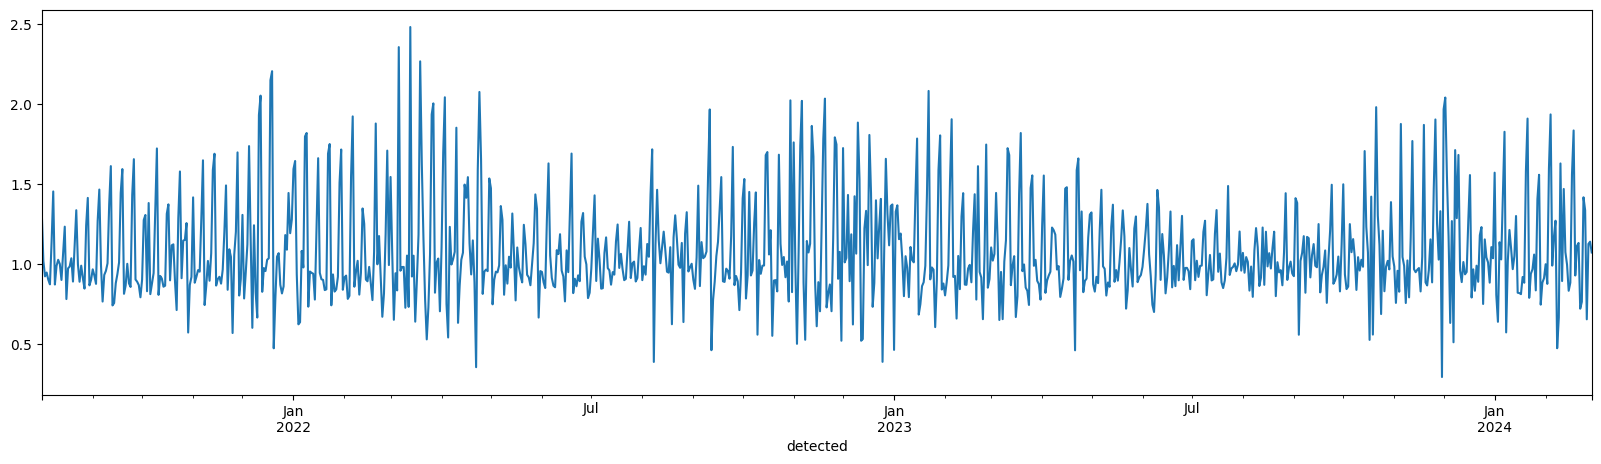

In [19]:
df_season_stl = df_decomp_stl.assign(seasonadjust = df_decomp_stl.observed / df_decomp_stl.trend)
df_season_stl.seasonadjust.plot(figsize=(20,5));
df_season_stl

### stl com slidewindows

In [20]:
def aplica_stl_boxcox(df, col='count_12', period=7):
    y = df[col].copy()
    
    # Estima lambda ótimo com método de Guerrero (necessário seasonal_length)
    best_lambda = boxcox_lambda(y, method='guerrero', season_length=period)
    
    # Aplica transformação Box-Cox
    y_boxcox = boxcox(y, lmbda=best_lambda)
    
    # Aplica STL
    stl = STL(y_boxcox, period=period, robust=True)
    decomp = stl.fit()
    
    # Reverte a transformação Box-Cox para as componentes
    def inv_boxcox(y, lmbda):
        if lmbda == 0:
            return np.exp(y)
        else:
            return np.power((y * lmbda) + 1, 1 / lmbda)
    
    df_decomp = pd.DataFrame({
        'observed': inv_boxcox(decomp.observed, best_lambda),
        'trend': inv_boxcox(decomp.trend, best_lambda),
        'seasonal': inv_boxcox(decomp.seasonal, best_lambda),
        'residual': inv_boxcox(decomp.resid, best_lambda),
    }, index=df.index)
    
    # Cria coluna ajustada pela sazonalidade
    df_decomp['seasonadjust'] = df_decomp['observed'] / df_decomp['trend']
    
    return df_decomp


In [21]:
resultados_stl = []
contador_id = 'count_12'
start_date = '2021-08-01'
end_date_inicial = '2022-07-31'
semanas_adicionadas = 0

# Janela inicial (52 semanas)
df_hist = df_corrigido_total.loc[start_date:end_date_inicial]

# 1) STL na janela inicial: guarda tudo
df_stl = aplica_stl_boxcox(df_hist, col=contador_id, period=7)
resultados_stl.append(df_stl)

while True:
    # 2) Avança 1 semana na janela móvel
    df_hist, semanas_adicionadas, conseguiu = get_one_more_week_rolling(
        df=df_corrigido_total,
        df_hist=df_hist,
        weeks_added=semanas_adicionadas,
        janela_semanas=52
    )
    if not conseguiu:
        print(f"Fim da análise para {contador_id}")
        break

    # 3) STL na nova janela móvel (52 semanas)
    df_stl_new = aplica_stl_boxcox(df_hist, col=contador_id, period=7)

    # 4) Seleciona só a última semana dos resultados (7 dias)
    ultima_semana_start = df_hist.index.max() - pd.Timedelta(days=6)
    df_stl_ultima_semana = df_stl_new.loc[ultima_semana_start:].copy()

    # 5) Acrescenta só essa última semana à coleção de resultados
    resultados_stl.append(df_stl_ultima_semana)

# 6) Junta todos os resultados para ter a série completa
df_todas_janelas = pd.concat(resultados_stl)

Fim da análise para count_12


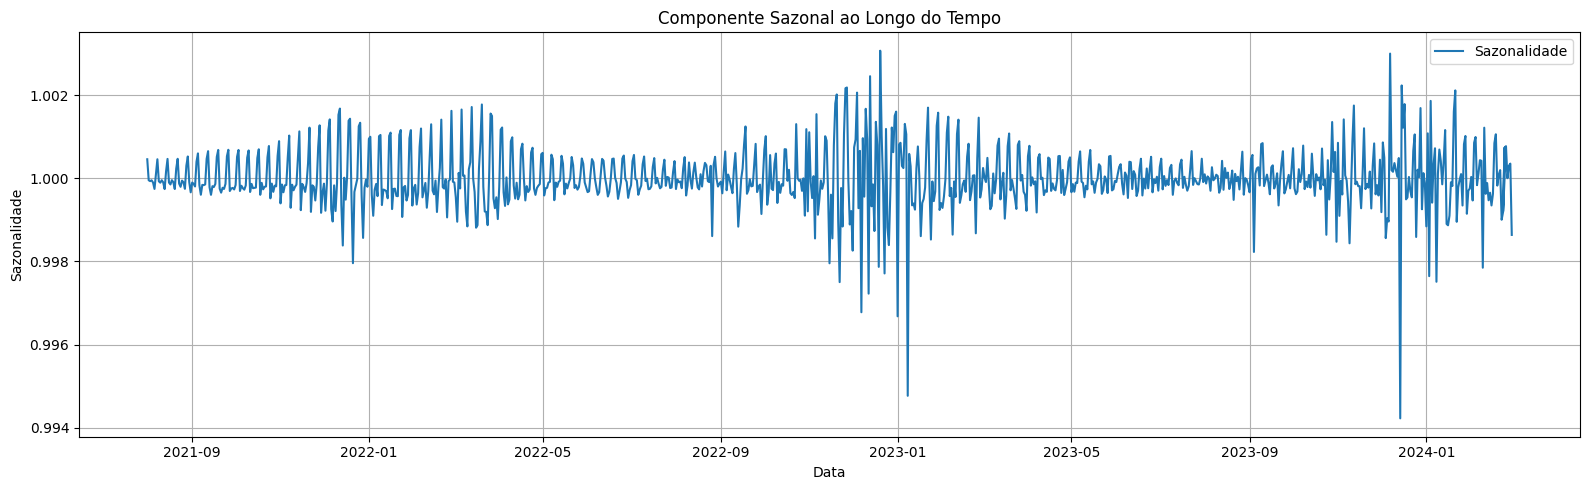

In [22]:
plt.figure(figsize=(16, 5))
plt.plot(df_todas_janelas.index, df_todas_janelas['seasonal'], label='Sazonalidade')
plt.title('Componente Sazonal ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Sazonalidade')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# Métodos tradicionais

In [23]:
def calcular_sr_si_resample(df, coluna, plotar=True, cores=None):
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    # Agregar por semanas que começam à segunda-feira (W-MON)
    df_semanal = df[coluna].resample('W-MON').agg(['mean', 'max']).dropna()
    df_semanal['SR'] = df_semanal['max'] / df_semanal['mean']
    df_semanal = df_semanal.reset_index()
    
    # Extrair ano e semana ISO
    df_semanal['ano'] = df_semanal['datetime'].dt.isocalendar().year
    df_semanal['semana'] = df_semanal['datetime'].dt.isocalendar().week

    # Calcular SI por ano
    resultados_si = []
    for ano, grupo in df_semanal.groupby('ano'):
        media_sr = grupo['SR'].mean()
        max_sr = grupo['SR'].max()
        si = media_sr / max_sr if max_sr != 0 else None
        resultados_si.append({
            'ano': ano,
            'SI': round(si, 4) if si is not None else None,
            'SR_medio': round(media_sr, 4),
            'SR_max': round(max_sr, 4)
        })

    df_si = pd.DataFrame(resultados_si).sort_values('ano').reset_index(drop=True)

    if plotar:
        anos = sorted(df_semanal['ano'].unique())
        if cores is None:
            cmap = plt.cm.tab10
            cores = {ano: cmap(i % 10) for i, ano in enumerate(anos)}
        
        plt.figure(figsize=(12, 12))

        plt.subplot(3, 1, 1)
        for ano in anos:
            subset = df_semanal[df_semanal['ano'] == ano].sort_values('semana')
            plt.plot(subset['semana'], subset['SR'], marker='o', linestyle='-', label=f'Ano {ano}', color=cores[ano])
        plt.axhline(1, color='red', linestyle='--', label='SR = 1 (sem sazonalidade)')
        plt.xlim(1, 53)
        plt.title('Seasonality Ratio (SR) por Semana e Ano')
        plt.xlabel('Semana do Ano')
        plt.ylabel('SR')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(df_si['ano'], df_si['SI'], marker='o', color='green', label='Seasonality Indicator (SI)')
        plt.axhline(1, color='red', linestyle='--', label='SI = 1 (sem sazonalidade)')
        plt.title('Seasonality Indicator (SI) por Ano')
        plt.xlabel('Ano')
        plt.ylabel('SI')
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return df_semanal, df_si

In [24]:
def calcular_indice_uteis_fds(df, coluna='count_', plotar=True, cores=None):
    df = df.copy()
    df = df.set_index('datetime')

    # Separar dias úteis e não úteis com base na coluna exog
    df_uteis = df[df['exog'] != 1]
    df_nao_uteis = df[df['exog'] == 1]

    # Média semanal com resample
    media_uteis = df_uteis[coluna].resample('W-MON').mean()
    media_nao_uteis = df_nao_uteis[coluna].resample('W-MON').mean()

    # Combinar os dois em um único DataFrame
    medias = pd.concat([media_uteis, media_nao_uteis], axis=1)
    medias.columns = ['media_uteis', 'media_nao_uteis']
    medias = medias.dropna(how='all')  # remover semanas totalmente vazias

    # Calcular os índices
    medias['indice_uteis_fds'] = medias['media_uteis'] / medias['media_nao_uteis']
    medias['indice_fds_uteis'] = medias['media_nao_uteis'] / medias['media_uteis']

    # Extrair ano e semana para plotagem
    medias['ano'] = medias.index.isocalendar().year
    medias['semana'] = medias.index.isocalendar().week

    if plotar:
        anos = sorted(medias['ano'].unique())
        if cores is None:
            cmap = plt.cm.tab10
            cores = {ano: cmap(i % 10) for i, ano in enumerate(anos)}

        plt.figure(figsize=(12, 6))

        for ano in anos:
            dados_ano = medias[medias['ano'] == ano]
            plt.plot(dados_ano['semana'], dados_ano['indice_uteis_fds'],
                     marker='o', linestyle='-', label=f'Ano {ano}', color=cores[ano])

        plt.yscale('log', base=2)
        
        valores_ticks = [0.33, 0.5, 1, 2, 3]

        # Coloca os ticks e os respetivos rótulos (labels) exatamente como queres
        plt.gca().set_yticks(valores_ticks)
        plt.gca().set_yticklabels(['3x não úteis', '2x não úteis', 'igual', '2x úteis', '3x úteis'])

        # Agora podes adicionar as linhas horizontais com valores originais
        plt.axhline(1, color='red', linestyle='--', label='Paridade (índice = 1)')
        plt.axhline(np.e, color='gray', linestyle=':', linewidth=1)         # ~2.72
        plt.axhline(1/np.e, color='gray', linestyle=':', linewidth=1)       # ~0.37
        plt.axhline(2, color='lightgray', linestyle=':', linewidth=1)
        plt.axhline(0.5, color='lightgray', linestyle=':', linewidth=1)

        plt.title('Índice Semanal: Média Dias Úteis / Média Dias Não Úteis')
        plt.xlabel('Semana do Ano')
        plt.ylabel('Índice (escala log)')
        plt.xlim(1, 53)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.tight_layout()
        plt.figtext(0.5, -0.04,
                    'Nota: Escala logarítmica apenas para simetria visual.\nValores >1 indicam mais movimento em dias úteis, <1 indicam dias não úteis.',
                    wrap=True, ha='center', fontsize=9)
        plt.show()

    return medias


In [25]:
df_corrigido_total = df_corrigido_total.reset_index()
df_corrigido_total = df_corrigido_total.rename(columns={'detected': 'datetime'})
df_corrigido_total['datetime'] = pd.to_datetime(df_corrigido_total['datetime'])

In [26]:
df_corrigido_total

,datetime,count_10,count_11,count_12,count_13,count_14,count_15,count_16,count_17,count_19,...,count_35,count_4,count_5,count_6,count_7,count_8,count_9,holiday,weekend,exog
0,2021-08-01,407.0,141.0,1663.0,308.0,121.0,84.0,830.0,279.0,638.0,...,1149.0,424.0,341.0,673.0,1092.0,106.0,1400.0,0,1,1
1,2021-08-02,219.0,112.0,1272.0,456.0,116.0,83.0,937.0,349.0,462.0,...,1163.0,372.0,364.0,907.0,1350.0,91.0,632.0,0,0,0
2,2021-08-03,245.0,155.0,1152.0,488.0,125.0,104.0,1073.0,391.0,539.0,...,1194.0,411.0,431.0,914.0,1347.0,115.0,860.0,0,0,0
3,2021-08-04,300.0,135.0,1182.0,448.0,105.0,99.0,1103.0,370.0,600.0,...,1236.0,423.0,404.0,890.0,1451.0,104.0,903.0,0,0,0
4,2021-08-05,246.0,144.0,1125.0,382.0,121.0,88.0,1042.0,338.0,471.0,...,1245.0,370.0,370.0,887.0,1342.0,107.0,823.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,2024-02-25,174.0,59.0,986.0,492.0,150.0,97.0,347.0,286.0,419.0,...,548.0,188.0,339.0,515.0,729.0,75.0,1008.0,0,1,1
939,2024-02-26,124.0,95.0,474.0,1198.0,217.0,152.0,584.0,418.0,488.0,...,608.0,316.0,732.0,1270.0,1515.0,112.0,370.0,0,0,0
940,2024-02-27,134.0,159.0,801.0,1539.0,357.0,212.0,665.0,443.0,539.0,...,780.0,377.0,1053.0,1584.0,2018.0,137.0,580.0,0,0,0
941,2024-02-28,164.0,159.0,798.0,1498.0,303.0,182.0,680.0,484.0,664.0,...,744.0,437.0,972.0,1560.0,2012.0,156.0,502.0,0,0,0


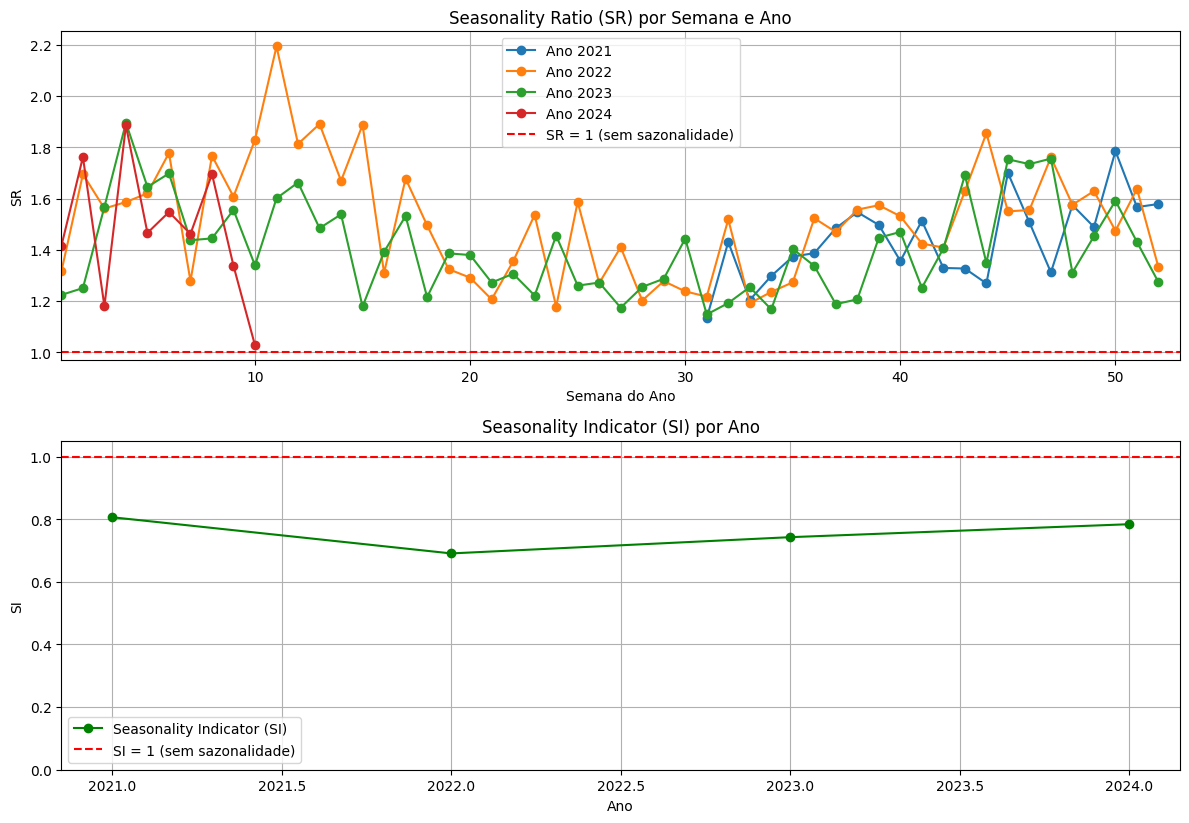

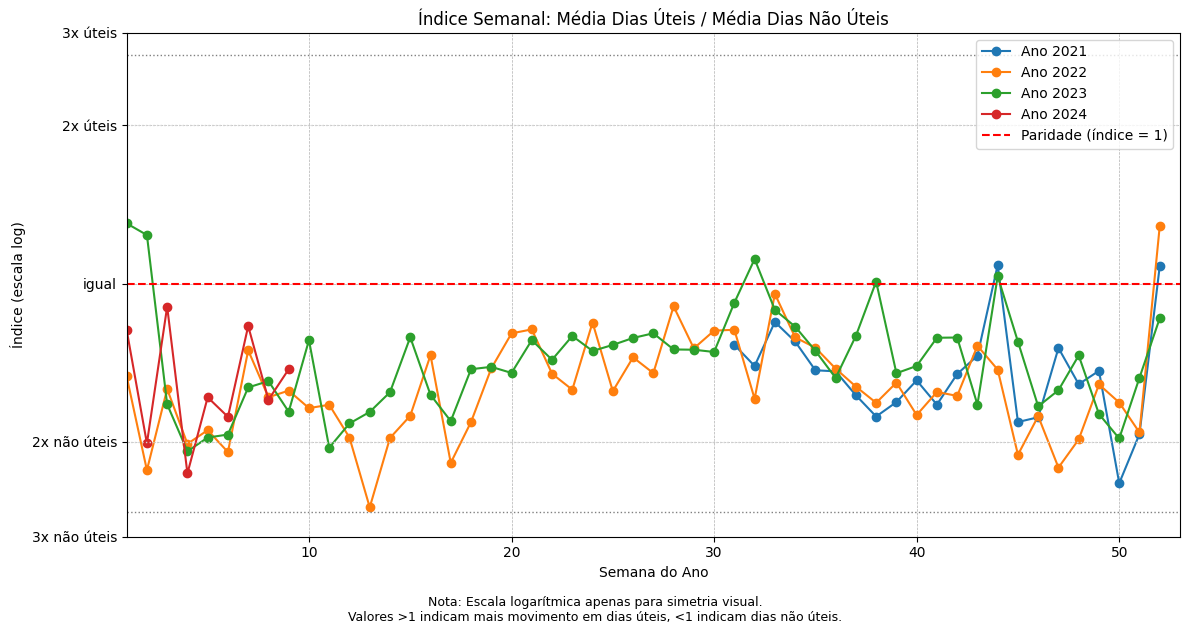

In [27]:
df_semanal, df_si  = calcular_sr_si_resample(df_corrigido_total, coluna='count_12', plotar=True)          
df_indices_uteis_fds= calcular_indice_uteis_fds(df_corrigido_total, coluna='count_12', plotar=True)

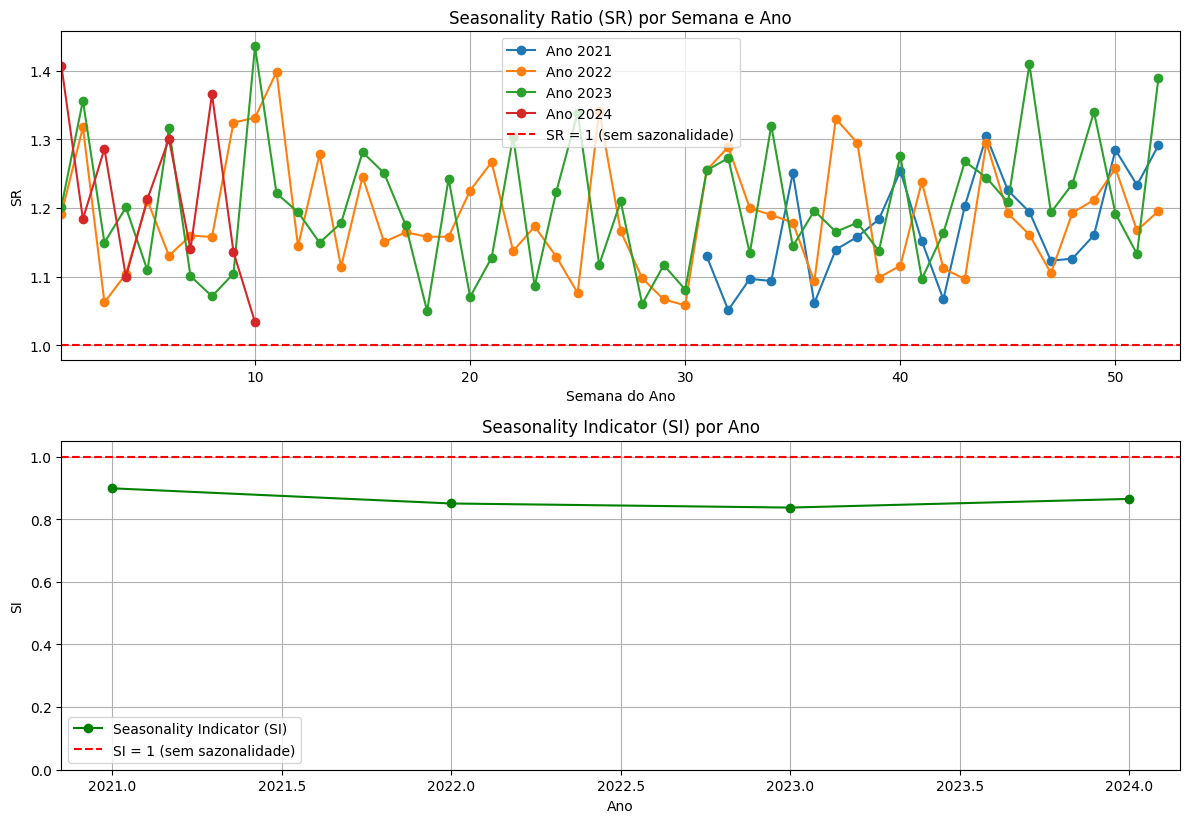

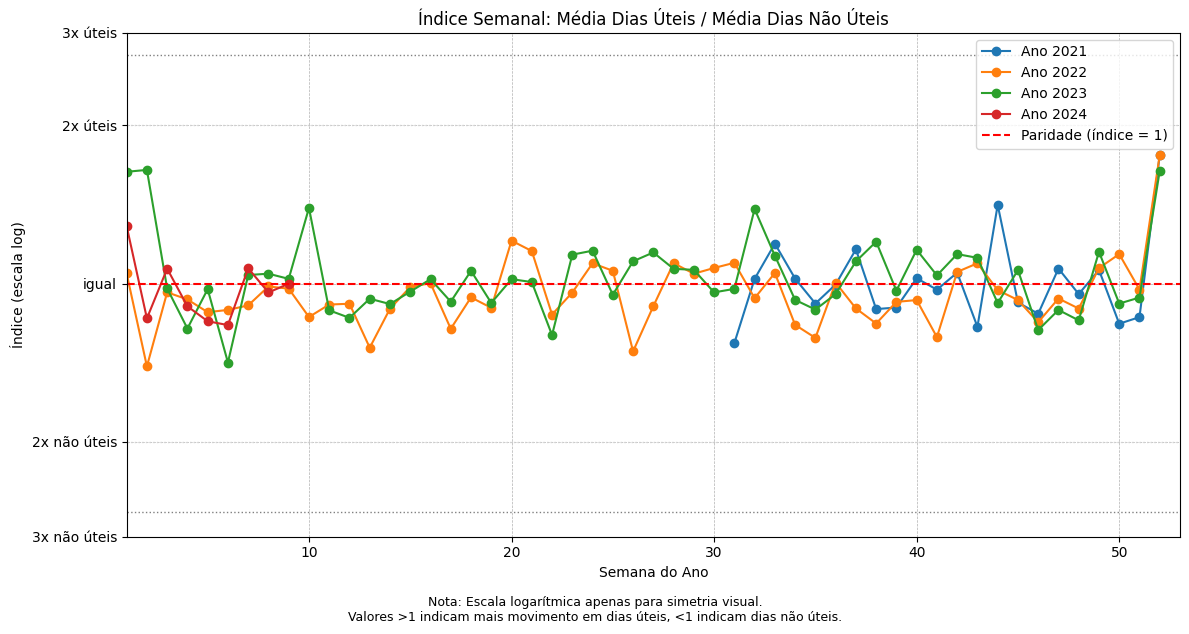

In [28]:
df_semanal, df_si   = calcular_sr_si_resample(df_corrigido_total, coluna='count_2', plotar=True)          
df_indices_uteis_fds= calcular_indice_uteis_fds(df_corrigido_total, coluna='count_2', plotar=True)

In [24]:
df_sem_tendencia = pd.DataFrame({
    'datetime': df_decomp_stl.index,
    'count_12': df_season_stl['seasonadjust']
})

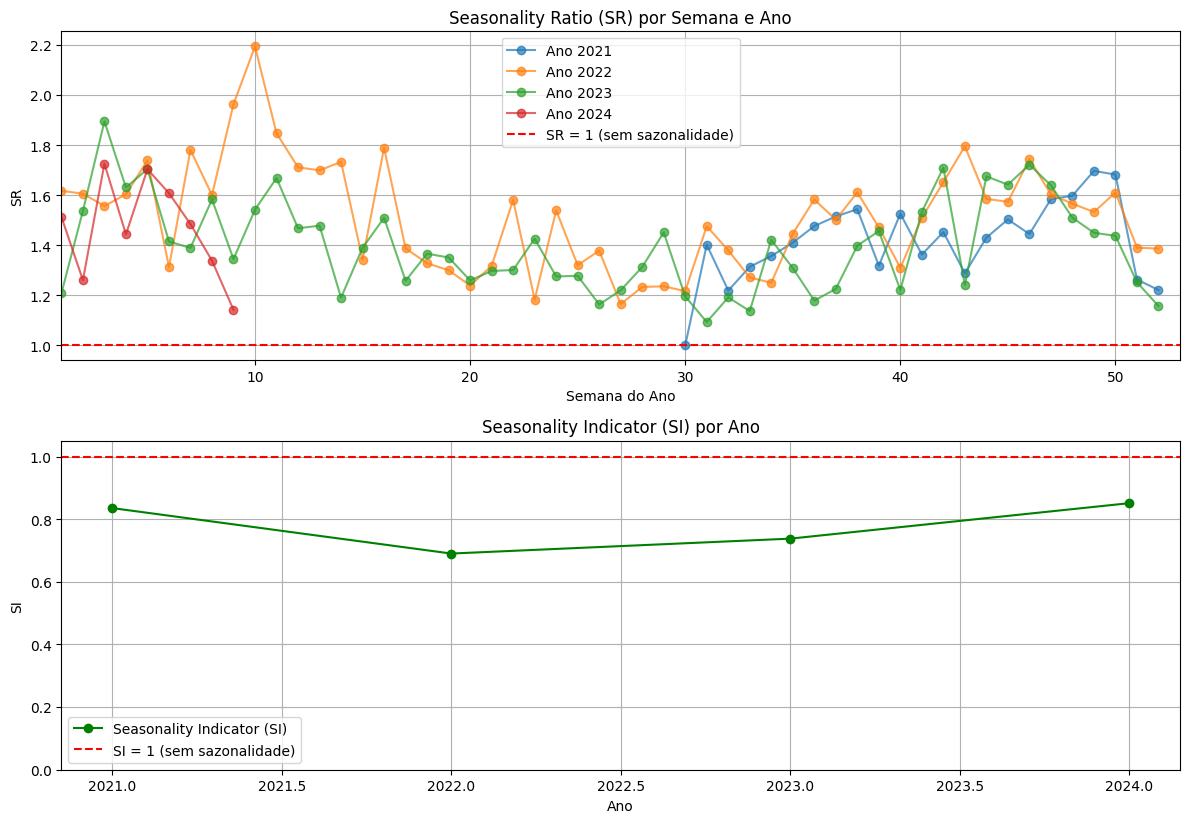

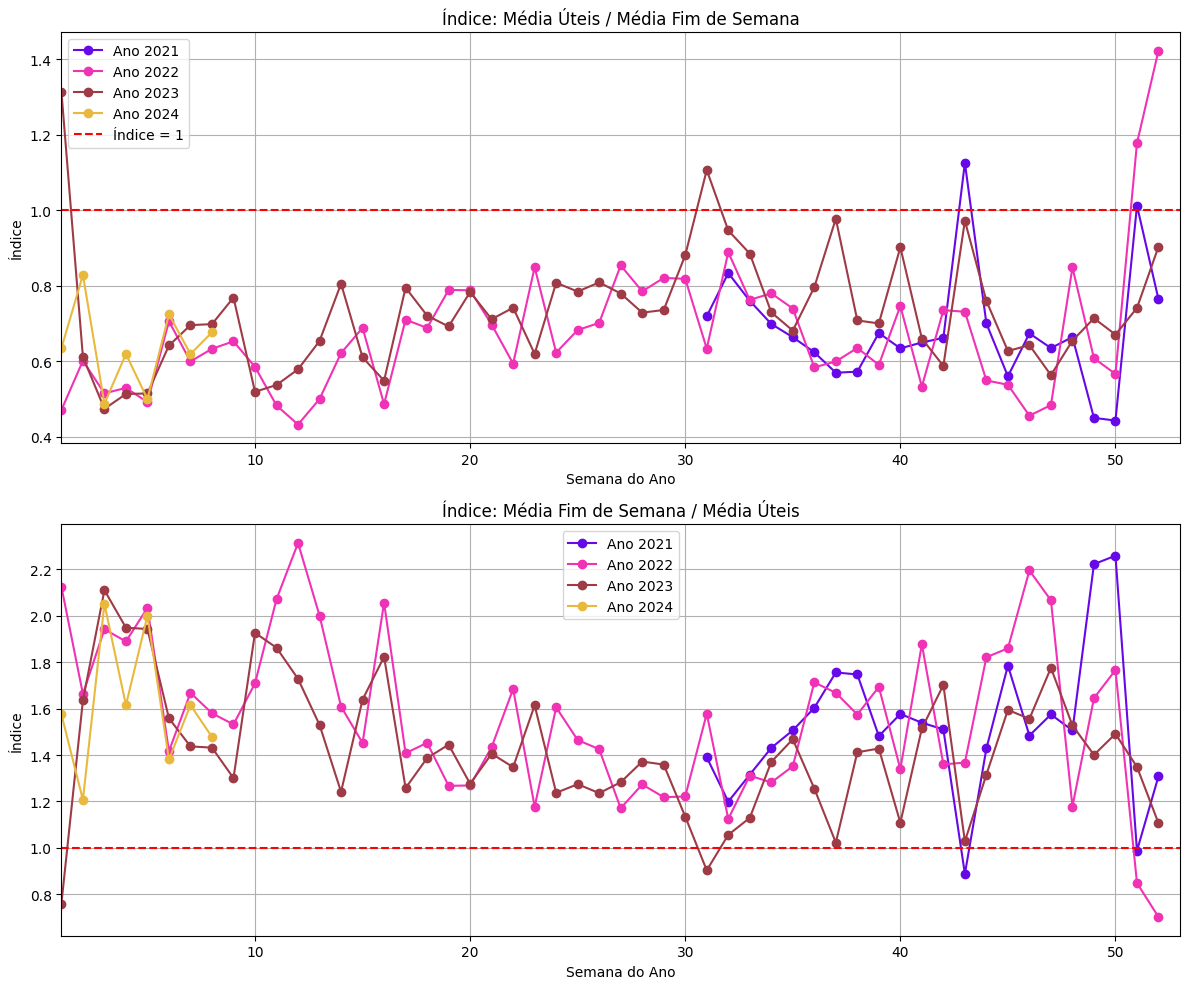

In [ ]:
cores_personalizadas = {
    2021: "#6608e8",
    2022: "#f032b4",
    2023: "#9e3b46", 
    2024: "#E9B93E"
}
df_sr_ano_semana, df_sr_semana, df_si = calcular_sr_si(df_sem_tendencia, coluna='count_12', plotar=True, cores=cores_personalizadas)
#df_indices_uteis_fds = calcular_indice_uteis_fds(df_sem_tendencia, coluna='count_12', plotar=True, cores=cores_personalizadas)

### Theil/entropia

In [29]:
def entropia_semanal(df, coluna='count_', plotar=True, data_inicio='2021-08-02', data_fim='2024-02-25'):
    from scipy.stats import entropy
    df = df.copy()
    df = df.set_index('datetime')

    data_inicio = pd.to_datetime(data_inicio)
    data_fim = pd.to_datetime(data_fim)
    df = df[(df.index >= data_inicio) & (df.index <= data_fim)]

    def calcular_entropia(x):
        x = np.array(x)
        if x.sum() == 0:
            return np.nan
        p = x / x.sum()
        return entropy(p, base=np.e)

    df_entropia = (
        df[coluna]
        .resample('W-MON')
        .apply(calcular_entropia)
        .reset_index(name='entropia')
    )

    # Calcular Theil (T) e Redundância relativa (R)
    df_entropia['T'] = np.log(7) - df_entropia['entropia']
    df_entropia['R'] = df_entropia['T'] / np.log(7)

    # Ano e semana ISO
    df_entropia['ano'] = df_entropia['datetime'].dt.isocalendar().year
    df_entropia['semana'] = df_entropia['datetime'].dt.isocalendar().week

    # Remover primeira e última semanas
    df_entropia = df_entropia.sort_values('datetime').iloc[1:-1].reset_index(drop=True)

    if plotar:
        plt.figure(figsize=(12, 15))

        for i, (col, title, ylabel) in enumerate([
            ('entropia', 'Entropia por Semana e Ano', 'Entropia'),
            ('T', 'Índice de Theil T por Semana e Ano', 'T'),
            ('R', 'Redundância Relativa R por Semana e Ano', 'R')
        ]):
            plt.subplot(3, 1, i+1)
            for ano in sorted(df_entropia['ano'].unique()):
                subset = df_entropia[df_entropia['ano'] == ano]
                plt.plot(subset['semana'], subset[col], marker='o', linestyle='-', label=f'Ano {ano}', alpha=0.7)
            plt.xlim(1, 53)
            plt.title(title)
            plt.xlabel('Semana do Ano')
            plt.ylabel(ylabel)
            plt.grid(True)
            plt.legend()

        plt.tight_layout()
        plt.show()

    return df_entropia

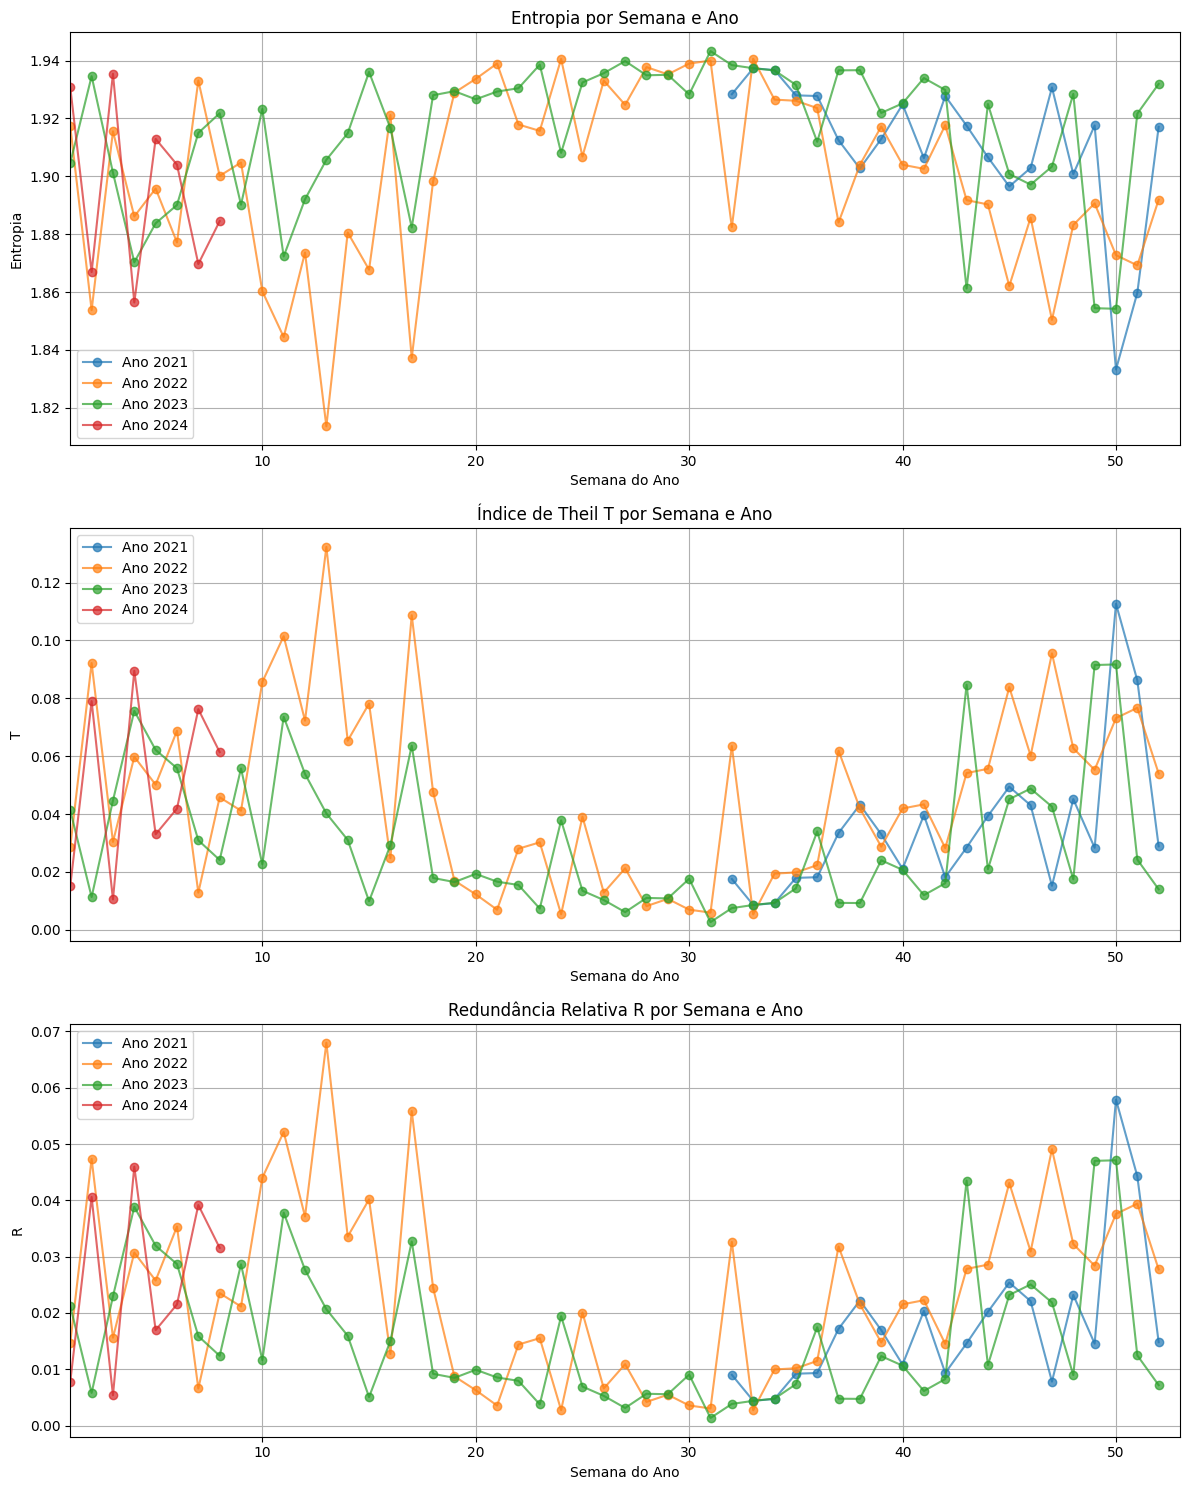

In [30]:
df_entorpia = entropia_semanal(df_corrigido_total, coluna='count_12', plotar=True )

In [31]:
print(df_entorpia['entropia'].max())
print(df_entorpia['entropia'].min())


1.9432653543322482
1.8136078011961771


In [32]:
df_entorpia.loc[df_entorpia['entropia'].idxmax()]

datetime    2023-07-31 00:00:00
entropia               1.943265
T                      0.002645
R                      0.001359
ano                        2023
semana                       31
Name: 103, dtype: object

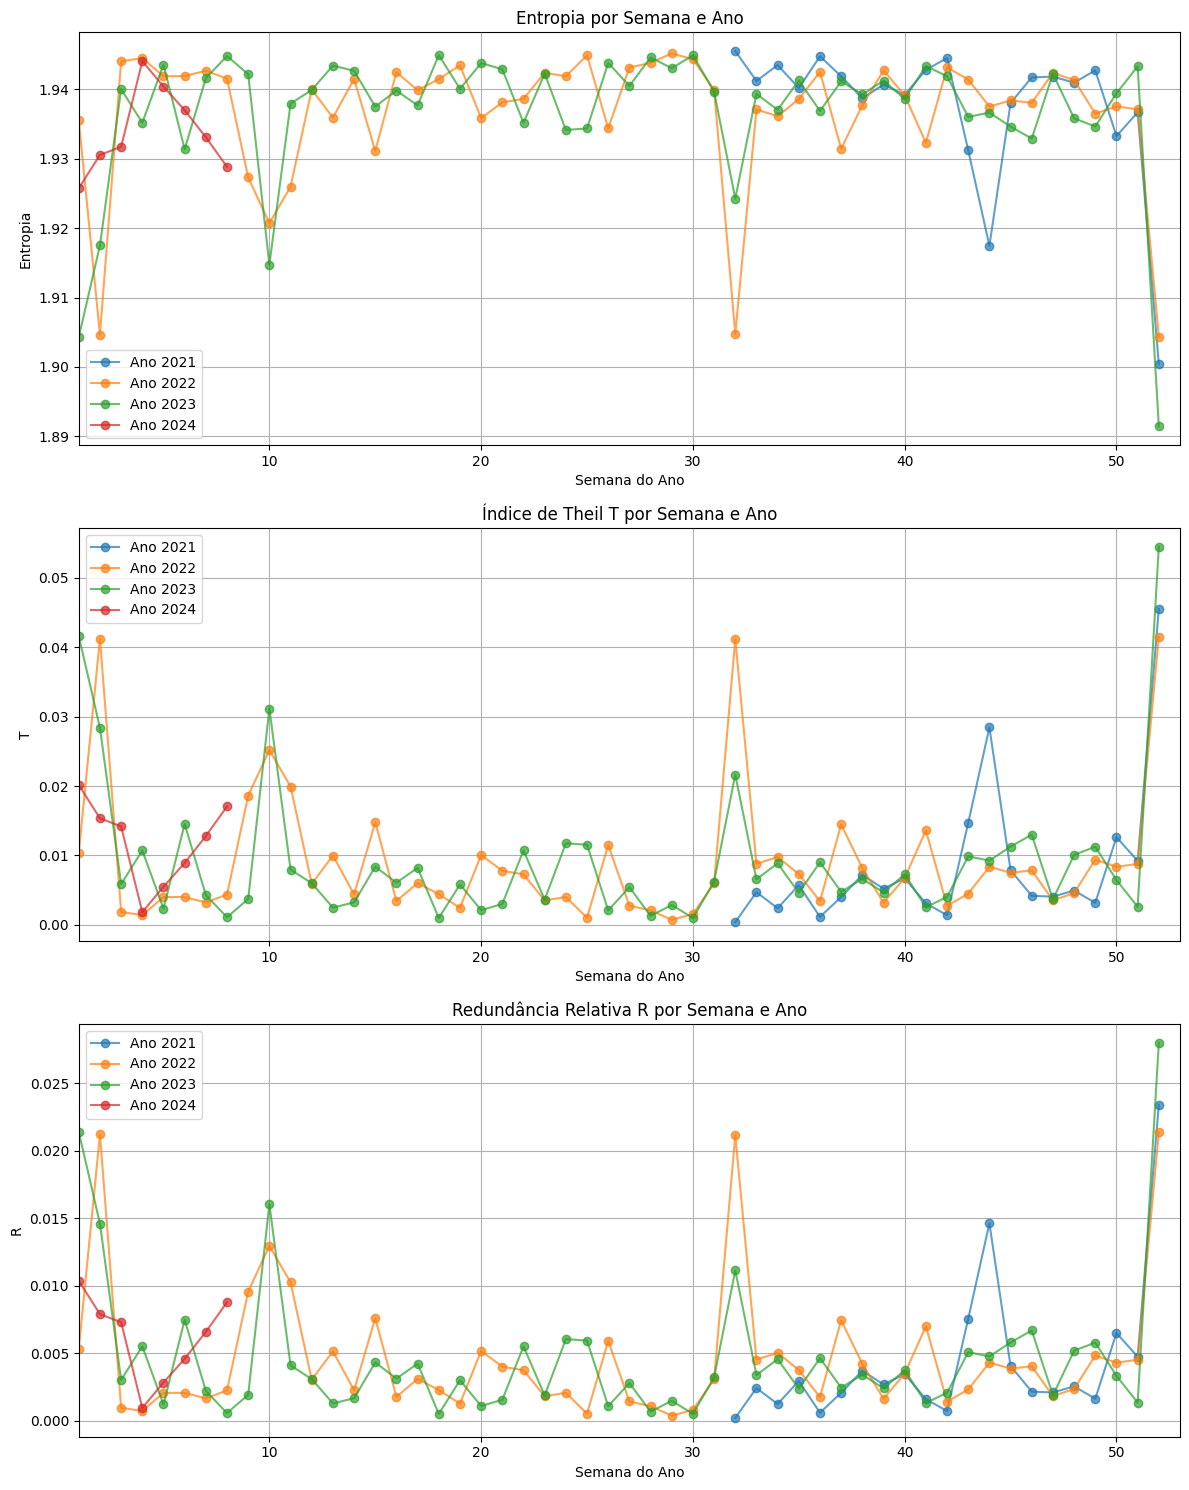

In [33]:
df_entorpia_2 = entropia_semanal(df_corrigido_total, coluna='count_2', plotar=True )

In [34]:
print(df_entorpia_2['entropia'].max())
print(df_entorpia_2['entropia'].min())

1.945530222274816
1.8914502788775347


### Indice de Gini (covariancia)

In [37]:
def gini_covariancia(y):
    y = np.array(y)
    n = len(y)
    if n == 0 or np.sum(y) == 0:
        return np.nan

    y_sorted = np.sort(y)
    F_y = (np.arange(1, n + 1)) / n  # função de distribuição empírica (percentis)
    y_mean = np.mean(y_sorted)

    cov = np.cov(y_sorted, F_y, bias=True)[0, 1]  # covariância com bias=True para dividir por n
    gini = (2 * cov) / y_mean
    return gini

In [38]:
def gini_cov_semanal(df, coluna='count_', plotar=True, cor='blue'):
    df = df.copy()
    df = df.set_index('datetime')

    # Calcular Gini para cada semana com resample
    df_gini_cov = (
        df[coluna]
        .resample('W-MON')  # Semanas com início à segunda-feira
        .apply(gini_covariancia)
        .reset_index(name='gini')
    )

    if plotar:
        plt.figure(figsize=(14, 5))
        plt.plot(df_gini_cov['datetime'], df_gini_cov['gini'], marker='o', color=cor)
        plt.title('Índice de Gini cov semanal ')
        plt.xlabel('Data (início da semana)')
        plt.ylabel('Gini')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df_gini_cov


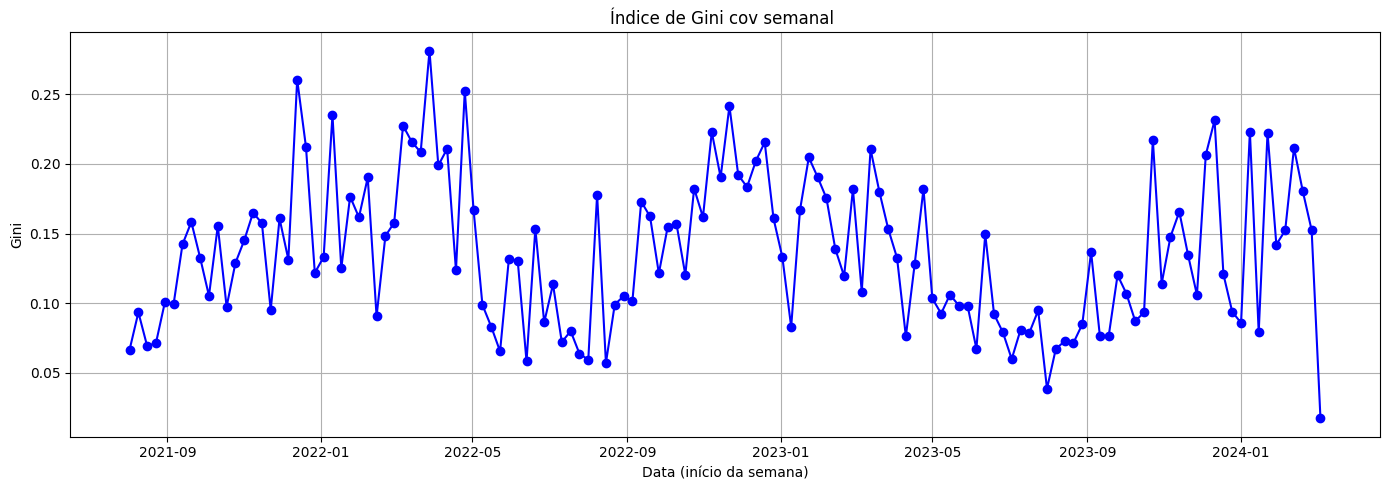

In [39]:
df_gini_cov = gini_cov_semanal(df_corrigido_total, coluna='count_12', plotar=True)
